Import files and merge on 'user_id'.

In [2]:
import pandas as pd

test_results = pd.read_csv("test_results.txt")
test_results.drop(test_results.columns[0], axis=1, inplace=True)
user_table = pd.read_csv("user_table.txt")

df = test_results.merge(user_table, on ='user_id')


Profile dataframe to see what columns should be removed.

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title='Pandas Profiling Report')
profile.to_file(output_file='profile.html')


Remove country, user_id (there are no repeat users, user_id is a column of uniques),
lat and long (they correspond to the city, so I just keep the city name).

In [3]:
df.drop(columns = ['lat', 'long', 'user_id', 'country'], inplace=True)

Fill Nans strategy:
- if 'operative_system' is Nan then replace with most frequent occurrence, based on 'device' column
- for all other columns with Nan (timestamp, source) replace with more frequent value

The % of missing values in timestamp and source is <0.1%.
The % of missing values in operative_system and operative_system is 6.4%.

In [4]:
df['operative_system']=df.groupby('device').operative_system.transform(lambda x: x.fillna(x.mode()[0]))
df = df.fillna(df.mode().iloc[0])

The column timestamp is a string.
Some timestamps have minutes and seconds values '60': I replace it with '00'.

Then I convert the timestamp column in timestamp format, so I can extract features of interest
such as hour, month, weekday, year, week number.

In [5]:
df['timestamp'] =df['timestamp'].str.replace('60', '00')
df['timestamp'] =pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S', errors = 'coerce')


df['hour'] = df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.weekday
df['year'] = df['timestamp'].dt.year
df['weeknum'] = df['timestamp'].dt.week


<ipython-input-5-3428c730e2d0>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weeknum'] = df['timestamp'].dt.week


Check for any seasonality: how many months/years has the test been run for?

In [6]:
print('Test months:',df['month'].value_counts())
#check how historical the data is
print('Test years:',df['year'].value_counts())


Test months: 5.0    99072
4.0    88840
3.0    87440
Name: month, dtype: int64
Test years: 2015.0    275352
Name: year, dtype: int64


The test is run for three months, so the data should not be affected by any seasonality.
Also, the test is run in the same year, so the column year can be dropped.
The column timestamp is dropped as well, as all the interesting features have been extracted from it.

In [7]:
df.drop(columns = ['year', 'timestamp'], inplace=True)

Check if the trial users have actually been displayed the price '59', by comparing the
lengths of the test columns with the price columns.

In [8]:
print(len(df[df['test']==1]))
print(len(df[df['price']==59.0]))

99188
98244


As the lengths of the columns are not the same as they should be, I remove the inconsistent rows from the dataset:
I will only keep the rows where test users were displayed the price 59 and non-test users were displayed the price 39.

In [9]:
df = df[(df['test']==1) & (df['price']==59.0) | (df['test']==0) & (df['price']==39.0)]

I can drop the column price as the column test already contains all the valuable information.
Also, I can simply drop the remaining Nans that result from bad timestamp conversions.

In [10]:
df.drop(columns = ['price'], inplace=True)
df = df.dropna()

Question 1.

I check if there is any statistically significant difference between the test and non-test users in
terms of conversion.

I obtain a contingency table from the columns test and converted, and I display the
row-wise percentage of the users that converted or not in test and non-test case.
It is necessary to consider the percentage of conversions rather than sheer numbers, as the number of
test users (33%) is less than half the number of non-test users (66%).

In [11]:
from scipy.stats import chi2_contingency

data_crosstab = pd.crosstab(df['test'],
                            df['converted'],
                            margins = False,
                            normalize = 'index')
chi2, p, dof, ex= chi2_contingency(data_crosstab)

print(p)

8.690384625029375e-08


A p-value smaller than the reference p-value 0.05 indicates that the difference is statistically significant.
This means that users in the non-test case converted significantly more than the users in the non- test case.

Question 3.

I can run the same chi2 test on data obtained in the first week of the A/B test
to see if the result is comparable with the data obtained running the test for 3 months.

I therefore retain only the data collected in the first week of the first month of the trial.

In [12]:
print('min month',df['month'].min())
days = df[df['month']==3.0]
print('min day in month 3',df['weekday'].min())

min month 3.0
min day in month 3 0.0


In [13]:
min_week_num = df['weeknum'].min()
first_week = df[(df['month']==3.0) & (df['weeknum']==min_week_num)]

In [14]:
data_crosstab = pd.crosstab(first_week['test'],
                            first_week['converted'],
                            margins = False,
                            normalize = 'index')
chi2, p, dof, ex= chi2_contingency(data_crosstab)

print(p)

3.332440638658952e-07


I obtain the outcome performing a chi2 test on the first week of data and in the whole three months of A/B testing.

Question 2.

I now segment the users to gain further insight into conversions.

I begin by dropping the test, month and week number columns, as I decide to not account for any seasonality in the data.

In [15]:
df.drop(columns = ['month','weeknum','test'], inplace=True)

The data I have is basically only categorical. I have no continuous variable to speak of,
so I cluster users using K-Modes (variant of K-means used for categorical data).


I begin by label-encoding the 'source', 'device', 'operative_system', 'city' columns.

In [16]:
from sklearn import preprocessing
df_enc = df
to_encode = ['source', 'device', 'operative_system', 'city']
le = preprocessing.LabelEncoder()

df_enc[to_encode] = df_enc[to_encode].apply(le.fit_transform)


Before proceeding I profile the new dataframe to check for any striking correlation between columns.

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df_enc, title='Pandas Profiling Report 2')
profile.to_file(output_file='profile_encoded.html')


There doesn't seem to be any striking correlation between any of the columns.

To make sure of the number of cluster, I use the knee method (importing KneeLocator from kneed) .

In [26]:
from kmodes.kmodes import KModes

cost=[]
for k in list(range(1,15)):
        print('Iteration number:', k)
        km = KModes(n_clusters=k, n_init = 1, verbose=1)
        km.fit(df_enc)
        cost.append(km.cost_)


Iteration number: 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1193262.0
Iteration number: 2
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4310, cost: 992366.0
Iteration number: 3
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4155, cost: 929700.0
Iteration number: 4
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3987, cost: 902859.0
Iteration number: 5
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 23037, cost: 871979.0
Iteration number: 6
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 20927, cost: 858158.0
Iteration number: 7
Init: initializing centroids
Init: initializing clusters
Start

In [33]:
from kneed import KneeLocator
print(cost)
kl = KneeLocator(
        range(1, 15), cost, curve="convex", direction="decreasing"
    )

n_clusters = kl.elbow
print(n_clusters)

[1193262.0, 992366.0, 929700.0, 902859.0, 871979.0, 858158.0, 838494.0, 827689.0, 795931.0, 776592.0, 769009.0, 755829.0, 750593.0, 749668.0]
3


The number of clusters chosen is 3, so I fit K-Modes with the parameter n_clusters = 3,
and I will cluster users based on its outcome.


In [34]:
from kmodes.kmodes import KModes

km = KModes(n_clusters=n_clusters, n_init = 1, verbose=1)
clusters = km.fit_predict(df_enc)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4155, cost: 929700.0


I re-encode the categorical variables and then I associate the cluster labels to the dataframe rows.

In [35]:
df_renc = df_enc.copy()
df_renc[to_encode].apply(le.fit_transform)

df_ind_res = df_renc.reset_index()

clustersDf = pd.DataFrame(clusters)
clustersDf.columns = ['cluster_predicted']
df_clusters = pd.concat([clustersDf, df_ind_res], axis = 1).reset_index()
df_clusters = df_clusters.drop(['index', 'level_0'], axis = 1)

I plot the clusters and their characteristics by category.

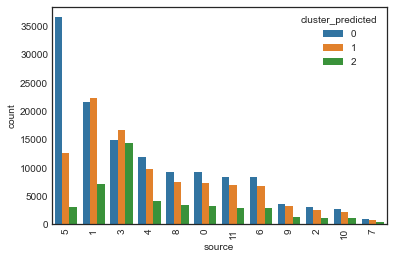

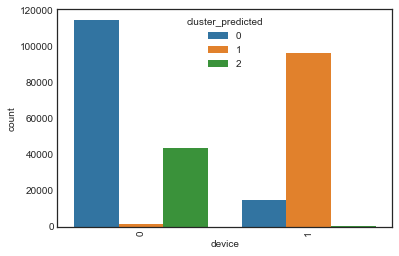

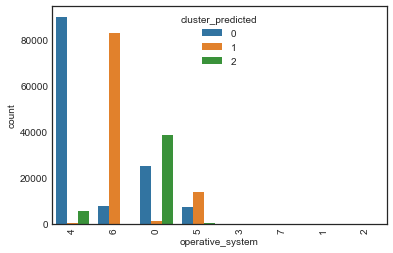

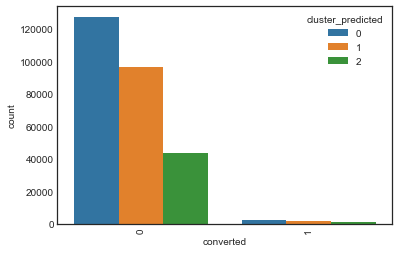

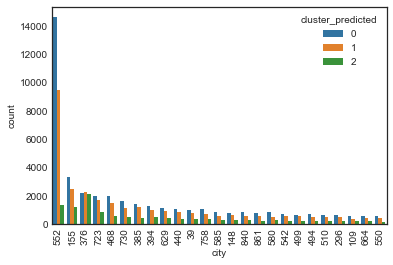

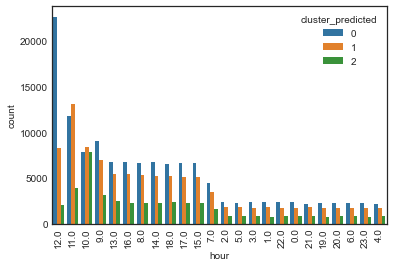

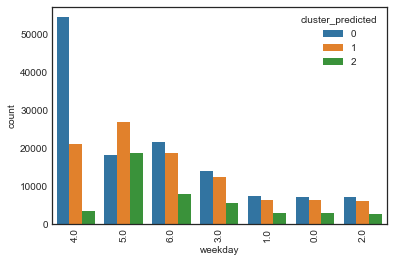

In [36]:
import seaborn as sns
from matplotlib import style
style.use('seaborn-white')
import matplotlib.pyplot as plt

cols_clusters = ['source','device', 'operative_system','converted','city','hour','weekday']


for col in df_enc.columns:

    if col == 'city':
        sns.countplot(x=df_clusters[col],order=df_clusters[col].value_counts()[:25].index,hue=df_clusters['cluster_predicted'])
        degrees = 90
        plt.xticks(rotation=degrees)
        plt.show()
    else:
        sns.countplot(x=df_clusters[col],order=df_clusters[col].value_counts().index,hue=df_clusters['cluster_predicted'])
        degrees = 90
        plt.xticks(rotation=degrees)
        plt.show()